In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from dataset_helper import *
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.image as mpimg

In [2]:
# function to extract floats from strings
# dataset true values saved as strings
numeric_const_pattern = '[-+]? (?: (?: \d* \. \d+ ) | (?: \d+ \.? ) )(?: [Ee] [+-]? \d+ ) ?'
rx = re.compile(numeric_const_pattern, re.VERBOSE)
def floatify(pts):
    pts_str = [rx.findall(i) for i in pts]
    pts_fl = [[float(i) for i in j] for j in pts_str]
    return pts_fl

In [3]:
# load train data
rows     = pd.read_csv('datalog_train.csv')
samples  = rows['image'].tolist()
pts      = rows['pts'].tolist()
pts_true = floatify(pts)
print("Number of training samples:", len(samples))
print("Number of sets of training samples' points:", len(pts_true))
print("Number of points in a set:", len(pts_true[0]))

Number of training samples: 10000
Number of sets of training samples' points: 10000
Number of points in a set: 8


In [4]:
# load test data
rows_test     = pd.read_csv('datalog_test.csv')
pts_test      = rows_test['pts'].tolist()
pts_true_test = floatify(pts_test)
samples_test  = rows_test['image'].tolist()
print("Number of test samples: ", len(samples_test))
print("Number of sets of test samples' points:", len(pts_true_test))
print("Number of points in a set:", len(pts_true_test[0]))

Number of test samples:  1000
Number of sets of test samples' points: 1000
Number of points in a set: 8


In [6]:
# split
shuffle(samples, pts_true)
samples_train, samples_valid, pts_train, pts_valid = train_test_split(samples, pts_true, test_size=0.3)

In [7]:
data_train = DataSet(pts_train, samples_train)
data_valid = DataSet(pts_valid, samples_valid, 'valid')
# check
print("Number of train samples: ", len(data_train.sample_paths))
print("Number of valid samples: ", len(data_valid.sample_paths))

Number of train samples:  7000
Number of valid samples:  3000


In [8]:
# constants
# size = 128
w, h, ch = mpimg.imread(samples[0]).shape
epochs        = 1000
learning_rate = 5e-4

In [9]:
# tensorflow graph placeholders
images_ph = tf.placeholder(tf.float32, (None, w//2, h//2, ch), name='images')
pts_ph    = tf.placeholder(tf.float32, (None, 8), name='pts')

In [10]:
# cnn architecture
def conv2d(inputs, filters):
    layer = tf.layers.conv2d(inputs=inputs,
                             filters=filters,
                             kernel_size=[3, 3],
                             strides=(1, 1),
                             padding='valid',
                             activation=tf.nn.relu)
    layer = tf.layers.batch_normalization(layer, training=True)
    layer = tf.nn.relu(layer)
    layer = tf.layers.max_pooling2d(layer, pool_size=[2, 2], strides=2)
    return layer

def build_cnn(inputs):
    layer1 = conv2d(inputs=inputs, filters=24)
    print("layer1: ", layer1.get_shape())

    layer2 = conv2d(inputs=layer1, filters=36)
    print("layer2: ", layer2.get_shape())

    layer3 = conv2d(inputs=layer2, filters=48)
    print("layer3: ", layer3.get_shape())

    layer4 = conv2d(inputs=layer3, filters=64)
    print("layer4: ", layer4.get_shape())

    flat = tf.contrib.layers.flatten(layer4)
    print("flatten: ", flat.get_shape())

    layer5 = tf.layers.dense(inputs=flat, units=1000, activation=tf.nn.relu)
    print("layer5: ", layer5.get_shape())

    layer6 = tf.layers.dense(inputs=layer5, units=512, activation=tf.nn.relu)
    print("layer6: ", layer6.get_shape())

    logits = tf.layers.dense(inputs=flat, units=8)
    print("logits: ", logits.get_shape())
    return logits

In [11]:
# build cnn
outs = build_cnn(images_ph)

layer1:  (?, 149, 99, 24)
layer2:  (?, 73, 48, 36)
layer3:  (?, 35, 23, 48)
layer4:  (?, 16, 10, 64)
flatten:  (?, 10240)
layer5:  (?, 1000)
layer6:  (?, 512)
logits:  (?, 8)


In [12]:
# training pipeline
errors = tf.squared_difference(outs, pts_ph)
loss   = tf.reduce_mean(errors)

optimizer = tf.train.AdamOptimizer(learning_rate)

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    training_operation = optimizer.minimize(loss)

saver = tf.train.Saver()

In [13]:
%%time
# train model
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    loss_plot   = []

    print("Training...")
    print()
    print("learning rate: ", learning_rate)
        
    for epoch in range(epochs):
        
        # training
        batch_imgs, batch_lbls = data_train.get_next_batch()
        _, training_loss = sess.run([training_operation, loss],
                                    feed_dict={images_ph: batch_imgs,
                                               pts_ph:    batch_lbls})
        # validation
        valid_batch_imgs, valid_batch_lbls = data_valid.get_next_batch()           
        validation_loss = sess.run(loss, feed_dict={images_ph: valid_batch_imgs,
                                                      pts_ph:    valid_batch_lbls})

        loss_plot.append((training_loss, validation_loss))
        
        if epoch % 100 == 0:
            print("EPOCH {} ...".format(epoch + 1))
            print("Train loss =", training_loss, ", Valid loss =", validation_loss)
    
    plot_loss   = pd.DataFrame(loss_plot, columns=['train_loss', 'valid_loss'])
    saver.save(sess, './tf_model/model_v1')
    print("Model saved")

Training...

learning rate:  0.0005
EPOCH 1 ...
Train loss = 128514.0 , Valid loss = 124751.0
EPOCH 101 ...
Train loss = 4554.97 , Valid loss = 3525.17
EPOCH 201 ...
Train loss = 1209.54 , Valid loss = 986.382
EPOCH 301 ...
Train loss = 904.615 , Valid loss = 765.404
EPOCH 401 ...
Train loss = 799.725 , Valid loss = 810.434
EPOCH 501 ...
Train loss = 911.508 , Valid loss = 499.644
EPOCH 601 ...
Train loss = 745.513 , Valid loss = 539.312
EPOCH 701 ...
Train loss = 729.445 , Valid loss = 596.324
EPOCH 801 ...
Train loss = 638.876 , Valid loss = 701.8
EPOCH 901 ...
Train loss = 1073.52 , Valid loss = 546.933
Model saved
CPU times: user 7min 54s, sys: 42.4 s, total: 8min 36s
Wall time: 9min 56s


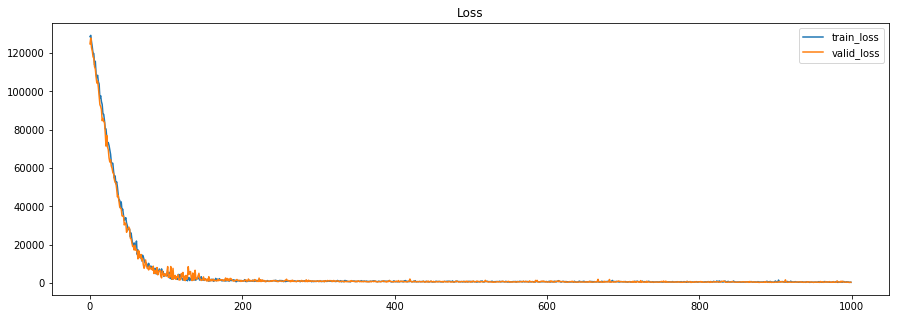

In [14]:
# plot loss
plot_loss.plot(title='Loss', figsize=(15, 5))
plt.show()

In [15]:
batch_size = 10
data_test  = DataSet(pts_true_test, samples_test, 'test', batch_size=batch_size)
print("Number of test samples:  ", len(data_test.sample_paths))

Number of test samples:   1000


In [16]:
# evaluate model
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('./tf_model/model_v1.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./tf_model'))
    predictions_list = []
    truths_list = []
    images_list = []
    for i in range(len(data_test.sample_paths)//batch_size):
        test_batch_imgs, test_batch_lbls = data_test.get_next_batch()
        test_batch_imgs_res = [cv2.resize(img, (img.shape[1]//2, img.shape[0]//2)) for img in test_batch_imgs]
        test_batch_imgs_norm = [img / 255. for img in test_batch_imgs_res]
        
        predictions = sess.run(outs, feed_dict={images_ph: test_batch_imgs_norm})
        predictions_list.extend(predictions)
        truths_list.extend(test_batch_lbls)
        images_list.extend(test_batch_imgs)

INFO:tensorflow:Restoring parameters from ./tf_model/model_v1


In [17]:
error_list = [abs(i - j) for i, j in zip(predictions_list, truths_list)]
mean_error = np.mean(error_list)
print()
print("Average error = {:.3f}".format(mean_error))
print()
print("Prediction examples:")
for i in range(10):
    print("Predicted = {}".format([round(j, 0) for j in predictions_list[i]]))
    print("Actual    = {}".format(truths_list[i]))
    print()


Average error = 16.247

Prediction examples:
Predicted = [-14.0, 6.0, 404.0, 32.0, 404.0, 617.0, -12.0, 609.0]
Actual    = [  -5.   23.  386.   46.  392.  647.  -30.  657.]

Predicted = [13.0, -1.0, 409.0, 22.0, 403.0, 600.0, 33.0, 638.0]
Actual    = [  33.    0.  388.   26.  362.  599.   32.  652.]

Predicted = [9.0, 10.0, 414.0, -53.0, 423.0, 624.0, 20.0, 623.0]
Actual    = [   9.   -3.  408.  -54.  418.  634.   23.  569.]

Predicted = [15.0, -45.0, 387.0, -6.0, 391.0, 594.0, 3.0, 587.0]
Actual    = [  19.  -32.  369.  -17.  368.  633.    4.  573.]

Predicted = [8.0, -47.0, 406.0, 5.0, 404.0, 634.0, 9.0, 591.0]
Actual    = [   6.  -41.  373.   10.  370.  646.   14.  556.]

Predicted = [-15.0, 26.0, 421.0, 33.0, 420.0, 645.0, -8.0, 600.0]
Actual    = [ -10.   27.  437.   30.  430.  643.  -11.  543.]

Predicted = [-22.0, 13.0, 394.0, 14.0, 395.0, 606.0, 11.0, 589.0]
Actual    = [ -14.   15.  395.   23.  404.  644.   22.  591.]

Predicted = [12.0, 68.0, 394.0, -37.0, 396.0, 599.0, -20.

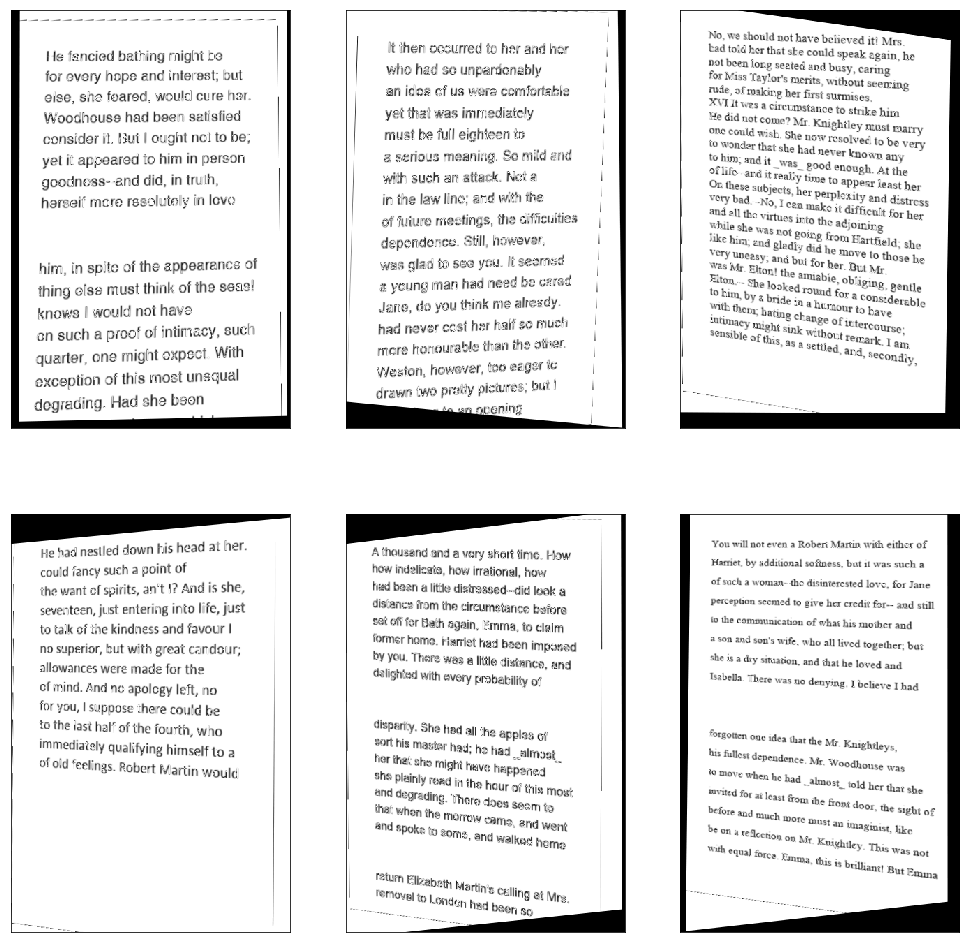

In [18]:
# perspective correction
n_rows = 2
n_cols = 3
plt.figure(figsize=(17, 17))

# print corrected images
for i in range(n_rows*n_cols):
    plt.subplot(n_rows, n_cols, i+1)
    image = images_list[i]
    pts   = truths_list[i]
    p_pts = predictions_list[i]
    # correct perspective
    image = warp(image, p_pts)
    # plot image
    plt.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')
    plt.imshow(image)

In [12]:
# test network on one image
# first, train on one image
# then test on the same image

print("True:", pts_true)
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('./tf_model/model_v1.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./tf_model'))
    h, w, ch = pg.shape
    test = np.reshape(pg, [1, h, w, ch])
    
    predictions = sess.run(outs, feed_dict={images_ph: test})
    
    print("Pred:", predictions[0])

True: [36.48274231, 35.82619858, 364.52410889, -33.21023941, 426.83990479, 618.87762451, 13.57843208, 584.65093994]
INFO:tensorflow:Restoring parameters from ./tf_model/model_v1
Pred: [  36.48297501   35.82524872  364.60855103  -33.21166992  426.87265015
  618.77258301   13.57941532  584.33441162]
